In [7]:
import numpy as np
import tvm
from tvm import relax
from tvm.contrib import utils, cc

from tvm.script import ir as I
from tvm.script import relax as R
from tvm.script import tir as T

In [8]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer((1, 128), "float32"),
              Y: T.Buffer((1, 128), "float32")):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer((1, 784), "float32"),
                W: T.Buffer((128, 784), "float32"),
                B: T.Buffer((128,), "float32"),
                Z: T.Buffer((1, 128), "float32")):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer((1, 128), "float32"),
                W: T.Buffer((10, 128), "float32"),
                B: T.Buffer((10,), "float32"),
                Z: T.Buffer((1, 10), "float32")):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            cls = MyModule
            lv0 = R.call_tir(cls.linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(cls.relu0, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(cls.linear1, (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [9]:
mod = MyModule
mod.show()

In [10]:
mod: tvm.IRModule = relax.transform.LegalizeOps()(mod)
mod.show()


In [11]:
mod: tvm.IRModule = relax.get_pipeline("zero")(mod)
mod.show()

target = tvm.target.Target("llvm -mtriple=aarch64-linux-gnu")
executable = relax.build(mod, target, exec_mode="compiled")
executable.export_library(file_name="linear_relu_mnist.so",
                          cc="/root/Programming/linux/customs/aarch64-linux-gnu/bin/aarch64-linux-gnu-g++",
                          options=["-nostdlib", "-shared", "-fPIC"])

In [12]:
import pickle as pkl
mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
import os
os.mkdir("weights")
print(mlp_params["w0"].shape, mlp_params["b0"].shape)
print(mlp_params["w1"].shape, mlp_params["b1"].shape)
mlp_params["w0"] = mlp_params["w0"].astype("float32")
mlp_params["b0"] = mlp_params["b0"].astype("float32")
mlp_params["w1"] = mlp_params["w1"].astype("float32")
mlp_params["b1"] = mlp_params["b1"].astype("float32")
mlp_params["w0"].tofile("weights/w0.bin")
mlp_params["b0"].tofile("weights/b0.bin")
mlp_params["w1"].tofile("weights/w1.bin")
mlp_params["b1"].tofile("weights/b1.bin")

(128, 784) (128,)
(10, 128) (10,)


In [13]:
import torchvision
import torch
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

100.0%
100.0%
100.0%
100.0%


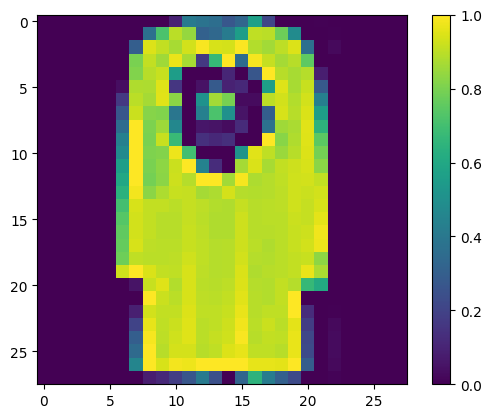

Class: Dress


In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [15]:
input_img = img.reshape(1, 784)

In [16]:
input_img.tofile("weights/input_img.bin")